In [46]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt

from CSWSEM import *

gs_name = 'pdim1'

In [48]:
def run_batch_exp(num_seeds,sem_kwargs,exp_kwargs):
  """ wrap wround seeds for single paramconfig
  """
  batch_dataL = []
  for seed in range(num_seeds):
    print('seed',seed)
    sem_kwargs['seed'] = seed
    # run
    sem = SEM(**sem_kwargs)
    task = CSWTask()
    exp,curr = task.generate_experiment(**exp_kwargs)
    sem_data = sem.forward_exp(exp,curr)
    # record
    sem.data.record_exp('condition',exp_kwargs['condition'])
    # collect
    sem_data_df = pd.DataFrame(sem_data,dtype='float64')
    batch_dataL.append(sem_data_df)
  return pd.concat(batch_dataL)

def run_BIexp(num_seeds,sem_kwargs,ntrain=NTRAIN,ntest=NTEST):
  """ wrap around task conditions
  """
  exp_dataL = []
  exp_kwargs = {'n_train':ntrain,'n_test':ntest}
  for cond in CONDL:
    exp_kwargs['condition'] = cond
    batch_data = run_batch_exp(num_seeds,sem_kwargs,exp_kwargs)
    exp_dataL.append(batch_data)
  return pd.concat(exp_dataL)

In [49]:
sem_kwargs={
  'nosplit':0,
  'alfa':10000000,
  'lmda':0.1,
  'seed':np.random.randint(99),
  'stsize':15,
  'learn_rate':0.05,
  'mode':5,
  'PE_thresh':None
}

In [50]:
DEBUG=1
if DEBUG:
  NTRAIN=40
  NTEST=2
  CONDL=['single','interleaved']
else:
  NTRAIN=160
  NTEST=40
  CONDL=['blocked','interleaved']

In [51]:
np.random.randint(2)

1

In [56]:
## GRIDSEARCH

n1 = 'mode'
L1 = [5] + ['Curr','Rand']
n2 = 'PE_thresh'
L2 = np.arange(0.11,0.161,0.02)
# L2 = [0.11,0.12,0.13]
print(L2)
num_seeds = 15

gsdataL = []
for idx,(v1,v2) in enumerate(itertools.product(L1,L2)):
  print(v1,v2)
  sem_kwargs[n1] = v1
  sem_kwargs[n2] = v2
  exp_data = run_BIexp(num_seeds,sem_kwargs)
  gsdataL.append(exp_data)
    
gsdata = pd.concat(gsdataL)
gsdata = gsdata.groupby(['condition','trial',n1,n2]).mean().reset_index()

[0.11 0.13 0.15]
5 0.11
seed 0
0.25089574498117523
seed 1
0.2606799343578068
seed 2
0.38516395566541234
seed 3
0.5193474306941419
seed 4
0.5184028475319321
seed 5
0.4037057897358578
seed 6
0.32004587427821163
seed 7
0.30373695989282845
seed 8
0.3633904760416533
seed 9
0.3281605329194695
seed 10
0.3344394461516894
seed 11
0.5009555079165618
seed 12
0.3349262869958011
seed 13
0.4158157848806767
seed 14
0.39109018461928957
seed 0
0.29139680905562226
seed 1
0.26389339730634004
seed 2
0.46828941446359734
seed 3
0.5029490031272064
seed 4
0.5249984447731209
seed 5
0.4783915761463516
seed 6
0.37422420681233964
seed 7
0.38031901596994805
seed 8
0.3724668281644645
seed 9
0.3988413621888083
seed 10
0.407599430989496
seed 11
0.506679812405199
seed 12
0.40482372883359014
seed 13
0.457851305132111
seed 14
0.5326399022258664
5 0.13
seed 0
0.25089574498117523
seed 1
0.2606799343578068
seed 2
0.38516395566541234
seed 3
0.5140060972391176
seed 4
0.5203173979635315
seed 5
0.42121410639211226
seed 6
0.320

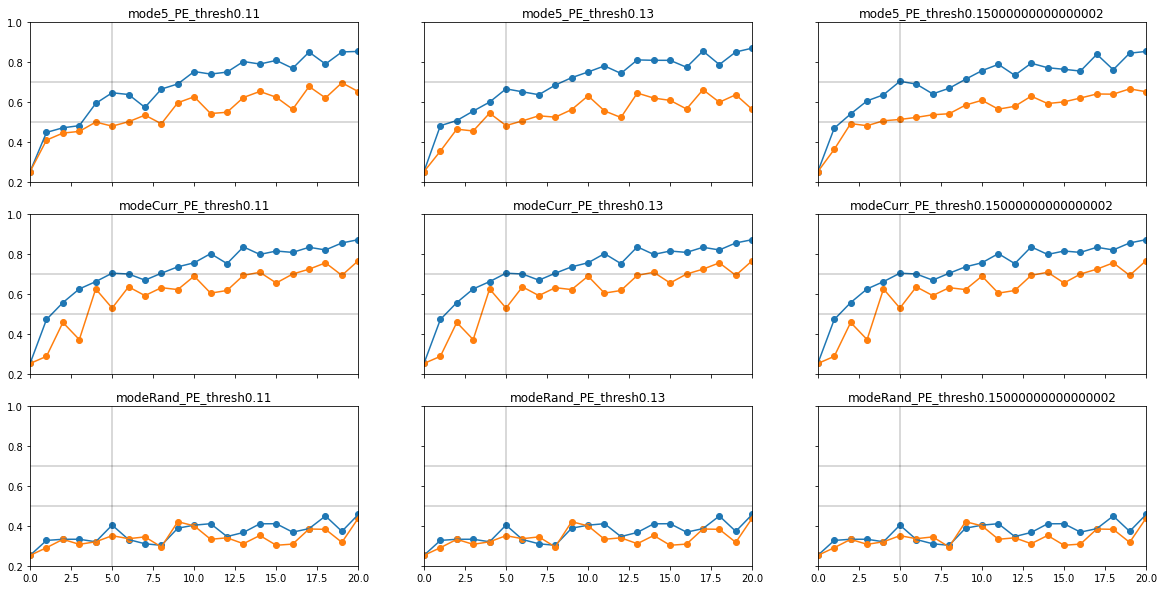

In [59]:
## PLT GRIDSEARCH
f,axar = plt.subplots(3,3,figsize=(20,10),sharey=True,sharex=True);axar=axar.reshape(-1)

for idx,(v1_,v2_) in enumerate(itertools.product(L1,L2)):
  ax = axar[idx]
  for c in CONDL:
    cdata = gsdata[(
      gsdata.condition==c)&(
      gsdata.loc[:,n1]==v1_)&(
      gsdata.loc[:,n2]==v2_)
    ]
    acc = 1-cdata.loss
    ax.plot(np.arange(len(acc)),acc)
    ax.scatter(np.arange(len(acc)),acc)
  ax.set_title('%s%s_%s%s'%(n1,v1_,n2,v2_))
  ax.set_ylim(0.2,1)
  ax.set_xlim(0,20)
  ax.axhline(0.5,c='k',lw=.3)
  ax.axhline(0.7,c='k',lw=.3)
  ax.axvline(5,c='k',lw=.3)
  ax.axvline(40,c='k',lw=.3)
  
# plt.savefig('figures/gs-%s&%s'%(n1,n2))